In [1]:
import pandas as pd
import numpy as np
import json
from scipy import sparse as sp
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
import implicit

In [3]:
import sys
sys.path.append('../')

from src.utils import get_shard_path
from src.utils import ProductEncoder, make_coo_row
from src.metrics import normalized_average_precision

In [4]:
product_encoder = ProductEncoder('../data/raw/products.csv')

In [40]:
a = product_encoder.getIdx
print(a)

{'0003020d3c': 0, '0003870676': 1, '0003ceaf69': 2, '000701e093': 3, '0007149564': 4, '0008bf7786': 5, '0009170c33': 6, '000b76558e': 7, '00117bd32b': 8, '0011ab9d97': 9, '0012a164c0': 10, '00145315d5': 11, '00146e3ac6': 12, '0016914eaa': 13, '00171ca87b': 14, '0017685f49': 15, '0018c79378': 16, '0019e02122': 17, '0019e7e1a4': 18, '001a0f9586': 19, '001ba8a3cf': 20, '001c41d0a0': 21, '001c7227b3': 22, '001c8e3b3a': 23, '001d019045': 24, '001eb0aeef': 25, '001ec733e0': 26, '001ed6661d': 27, '0020caa486': 28, '002414bc63': 29, '0028f73ec0': 30, '002990f70e': 31, '002c59c78b': 32, '002cd4c65d': 33, '002d604296': 34, '002f491a94': 35, '0031bd9d04': 36, '003234102a': 37, '00332f44b8': 38, '00347c06a0': 39, '00365ad3e3': 40, '0036cc0304': 41, '003a68a4c1': 42, '003abd5c49': 43, '003c9e27fb': 44, '003d44f6fd': 45, '003d455033': 46, '003d6ea38d': 47, '003dd7b7f3': 48, '0042a63275': 49, '00434b59a2': 50, '0043d0725f': 51, '004be38569': 52, '004c126130': 53, '004e3f16a4': 54, '004f9fdfa2': 55, '

In [5]:
valid_data = [json.loads(l) for l in open(get_shard_path(7))][:3000]

In [6]:
rows = []
for shard_id in range(4):
    for js in tqdm(json.loads(l) for l in open(get_shard_path(shard_id))):
        rows.append(make_coo_row(js["transaction_history"], product_encoder))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
len(rows)


183938

In [8]:
X_sparse = sp.vstack(rows).tocsr()

In [9]:
X_sparse.shape

(183938, 43038)

In [10]:
X_sparse

<183938x43038 sparse matrix of type '<class 'numpy.float32'>'
	with 12918657 stored elements in Compressed Sparse Row format>

# ALS

In [11]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)
model.fit(X_sparse) #!!!!!!!!!!!!!!!

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
m_ap = []
for js in tqdm(valid_data):
    row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
    raw_recs = model.recommend(
        0, 
        row_sparse, #текущий пользователь, для которого рекомендуем
        N=30, 
        filter_already_liked_items=False, 
        recalculate_user=True
    )
    recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
    gt_items = js["target"][0]["product_ids"]
    m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
print(np.mean(m_ap))

  0%|          | 0/3000 [00:00<?, ?it/s]

0.05351764358380956


In [13]:
raw_recs

(array([12454,  1713, 36967, 40445, 12790, 39321,  4740,  1337, 37296,
        41355, 26079, 34153, 28825, 39862, 39153, 38802, 41915,  8809,
        42416, 36370, 18919, 34902, 23687, 41070,  2157, 15237,  6458,
        12751, 33527, 13455]),
 array([1.0011280e+00, 3.7531853e-03, 2.8436063e-03, 2.8225370e-03,
        2.5503049e-03, 2.1508043e-03, 1.7332104e-03, 1.6045189e-03,
        1.4556982e-03, 1.3464480e-03, 1.3436036e-03, 1.2987014e-03,
        1.0319095e-03, 1.0194948e-03, 9.6356845e-04, 7.9073873e-04,
        7.7742408e-04, 7.3313998e-04, 7.3204620e-04, 6.5696472e-04,
        6.0403644e-04, 5.3423445e-04, 5.2990438e-04, 5.2476791e-04,
        5.1745342e-04, 5.1144685e-04, 4.8850640e-04, 4.5886659e-04,
        4.1881547e-04, 4.1571568e-04], dtype=float32))

0.053
раньше было лучше...
уберём нормировку - переопределим функцию make_coo_row:

## Без нормировки

In [14]:
def make_coo_row(transaction_history, product_encoder: ProductEncoder):
    idx = []
    values = []

    items = []
    for trans in transaction_history:
        items.extend([i["product_id"] for i in trans["products"]])
    n_items = len(items)

    for pid in items:
        idx.append(product_encoder.toIdx(pid))
        values.append(1.0)

    return sp.coo_matrix(
        (np.array(values).astype(np.float64), ([0] * len(idx), idx)), shape=(1, product_encoder.num_products),
    )

In [15]:
rows = []
for shard_id in range(4):
    for js in tqdm(json.loads(l) for l in open(get_shard_path(shard_id))):
        rows.append(make_coo_row(js["transaction_history"], product_encoder))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [16]:
X_sparse = sp.vstack(rows).tocsr()

In [17]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)
model.fit(X_sparse) #!!!!!!!!!!!!!!!

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
m_ap = []
for js in tqdm(valid_data):
    row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
    raw_recs = model.recommend(
        0, #id пользователя
        row_sparse, #текущий пользователь, для которого рекомендуем
        N=30, 
        filter_already_liked_items=False, 
        recalculate_user=True
    )
    recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
    gt_items = js["target"][0]["product_ids"]
    m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
print(np.mean(m_ap))

  0%|          | 0/3000 [00:00<?, ?it/s]

0.07268809503779691


## factors?

In [21]:
m_ap_arr = []
for factors in [1, 2, 5, 10, 16, 30, 50]:
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.0, iterations=8)
    model.fit(X_sparse) #!!!!!!!!!!!!!!!
    m_ap = []
    for js in tqdm(valid_data):
        row_sparse = make_coo_row(js["transaction_history"], product_encoder).tocsr()
        raw_recs = model.recommend(
            0, #id пользователя
            row_sparse, #текущий пользователь, для которого рекомендуем
            N=30, 
            filter_already_liked_items=False, 
            recalculate_user=True
        )
        recommended_items = product_encoder.toPid([x for x in raw_recs[0]])
        gt_items = js["target"][0]["product_ids"]
        m_ap.append(normalized_average_precision(gt_items, recommended_items, k=30))
    m_ap_arr.append(np.mean(m_ap))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
import matplotlib.pyplot as plt

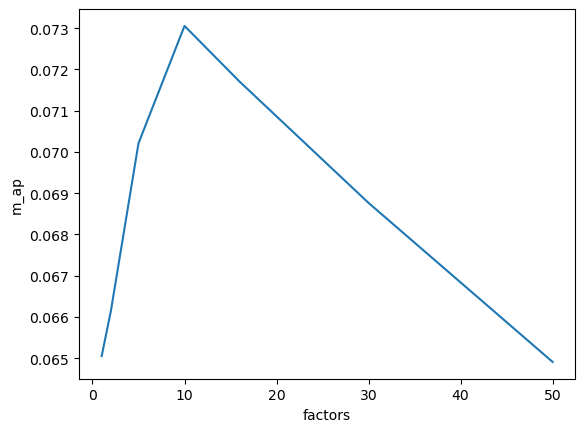

In [26]:
plt.plot([1, 2, 5, 10, 16, 30, 50], m_ap_arr)
plt.xlabel("factors")
plt.ylabel("m_ap")
plt.show()